In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DeFungi_Dataset

/content/drive/MyDrive/DeFungi_Dataset


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score ,precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob
import pandas as pan
import matplotlib.pyplot as plotter
import warnings
warnings.filterwarnings('ignore')
# Handling images
from PIL import Image
# Handling paths
import time
# data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2
import shutil

In [ ]:
root_path = '/content/drive/MyDrive/DeFungi_Dataset/'
df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
label_dict = {
    "H1":0,
    "H2":1,
    "H3":2,
    "H5":3,
    "H6":4,
}
for key in label_dict:
    img_path = os.path.join(root_path, key)
    jpg_list = glob(img_path+'/*.jpg')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":key, "class_id":label_dict[key]}, index=[1])
        df = pd.concat([df, new_data], ignore_index=True)

df[["path"]] = df[["path"]].astype(str)
df[["label"]] = df[["label"]].astype(str)
df[["class_id"]] = df[["class_id"]].astype(int)
df.head()

,path,label,class_id
0,/content/drive/MyDrive/DeFungi_Dataset/H1/H1_7...,H1,0
1,/content/drive/MyDrive/DeFungi_Dataset/H1/H1_7...,H1,0
2,/content/drive/MyDrive/DeFungi_Dataset/H1/H1_7...,H1,0
3,/content/drive/MyDrive/DeFungi_Dataset/H1/H1_7...,H1,0
4,/content/drive/MyDrive/DeFungi_Dataset/H1/H1_7...,H1,0


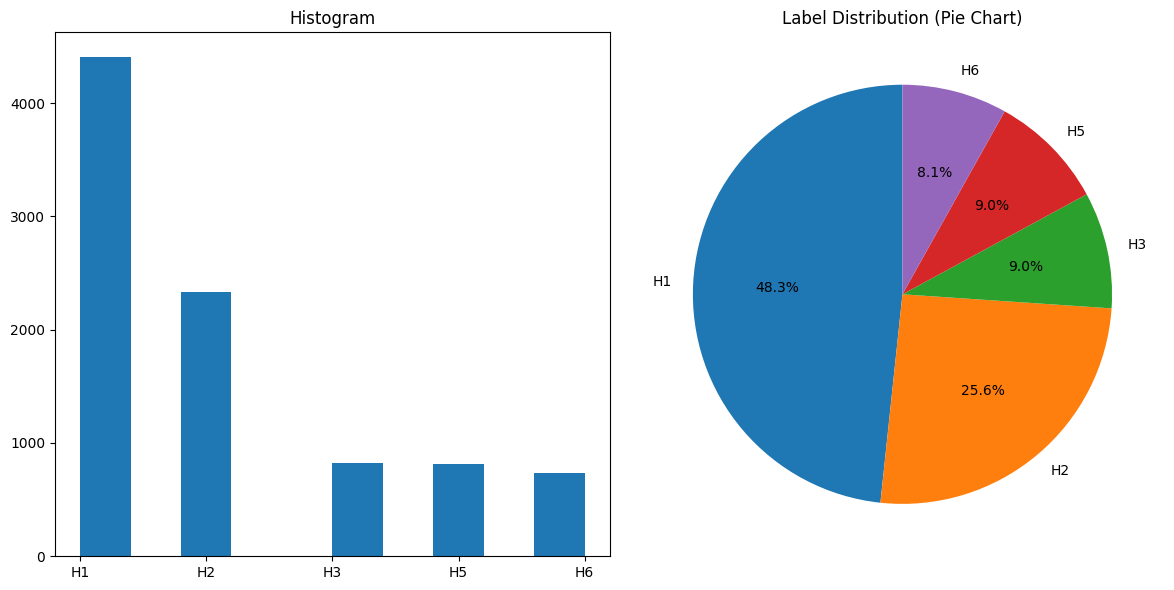

In [ ]:

# Assuming df['label'] is a categorical column in your DataFrame
label_counts = df['label'].value_counts()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the histogram
axs[0].hist(df['label'])
axs[0].set_title('Histogram')

# Plotting the pie chart
axs[1].pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Label Distribution (Pie Chart)')

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()


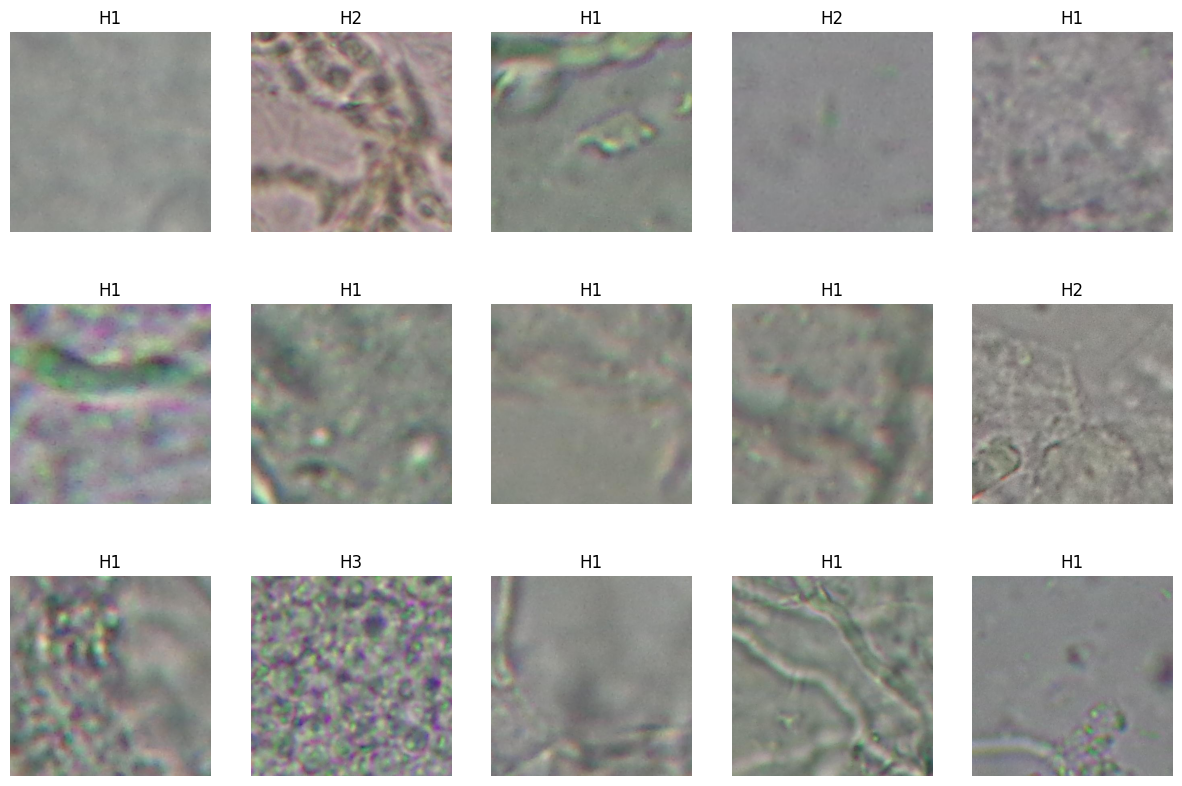

In [ ]:
show_imgs = 15
idx = np.random.randint(0, len(df),size=show_imgs)
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(df.loc[idx[i]]['label'])
    ax.set_axis_off()


In [ ]:
train_data_dir =root_path
batch_size = 32
target_size = (224,224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

Found 9114 files belonging to 5 classes.
Using 7292 files for training.
Found 9114 files belonging to 5 classes.
Using 1822 files for validation.


# Training using resnet

In [ ]:
# base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224,224,3),include_top=False,weights='imagenet')
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
# Load ResNet50 model with pre-trained weights
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

base_model.trainable = False
keras_model=keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.Flatten())
keras_model.add(keras.layers.Dropout(0.5))
keras_model.add(keras.layers.Dense(5,activation=tf.nn.softmax))
keras_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_1 (Dropout)         (None, 100352)            0         
                                                                 
 dense_1 (Dense)             (None, 5)                 501765    
                                                                 
Total params: 24089477 (91.89 MB)
Trainable params: 501765 (1.91 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


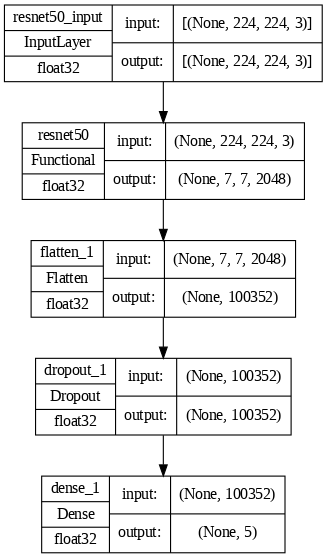

In [ ]:
tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [ ]:
#with resnet
checkpoint =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping =EarlyStopping(patience=5, restore_best_weights=True)
keras_model.compile(optimizer ='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist=keras_model.fit_generator(train,epochs=15,validation_data=validation,callbacks=[checkpoint,early_stopping])

Epoch 1/15
228/228 [==============================] - 227s 968ms/step - loss: 2.8250 - accuracy: 0.6282 - val_loss: 1.2034 - val_accuracy: 0.8030
Epoch 2/15
228/228 [==============================] - 33s 140ms/step - loss: 1.5552 - accuracy: 0.7885 - val_loss: 0.9845 - val_accuracy: 0.8310
Epoch 3/15
228/228 [==============================] - 32s 138ms/step - loss: 1.1564 - accuracy: 0.8375 - val_loss: 0.6443 - val_accuracy: 0.8952
Epoch 4/15
228/228 [==============================] - 31s 134ms/step - loss: 1.0053 - accuracy: 0.8589 - val_loss: 0.9949 - val_accuracy: 0.8809
Epoch 5/15
228/228 [==============================] - 31s 135ms/step - loss: 0.8763 - accuracy: 0.8801 - val_loss: 1.0279 - val_accuracy: 0.8529
Epoch 6/15
228/228 [==============================] - 31s 135ms/step - loss: 0.8375 - accuracy: 0.8858 - val_loss: 0.7100 - val_accuracy: 0.9160
Epoch 7/15
228/228 [==============================] - 36s 155ms/step - loss: 0.7801 - accuracy: 0.8982 - val_loss: 0.5511 - val_a

In [ ]:
# Calculate precision, recall, and F1 on the validation set
val_steps = len(validation)
val_labels = []
val_preds = []

validation_iterator = iter(validation)

for i in range(val_steps):
    val_data, val_label = next(validation_iterator)
    val_labels.extend(val_label.numpy())
    val_pred = keras_model.predict(val_data)
    val_preds.extend(val_pred.argmax(axis=1))

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)

val_precision = precision_score(val_labels, val_preds, average='weighted')
val_recall = recall_score(val_labels, val_preds, average='weighted')
val_f1 = f1_score(val_labels, val_preds, average='weighted')

print('Validation Precision:', val_precision)
print('Validation Recall:', val_recall)
print('Validation F1 Score:', val_f1)



1/1 [==============================] - 1s 993ms/step
Validation Precision: 0.9355408624756529
Validation Recall: 0.9346871569703622
Validation F1 Score: 0.9349291907065027


## Trainig using MobileNetV3Small

In [ ]:
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
keras_model=keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.Flatten())
keras_model.add(keras.layers.Dropout(0.5))
keras_model.add(keras.layers.Dense(5,activation=tf.nn.softmax))
keras_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 28224)             0         
                                                                 
 dropout_2 (Dropout)         (None, 28224)             0         
                                                                 
 dense_2 (Dense)             (None, 5)                 141125    
                                                                 
Total params: 1080245 (4.12 MB)
Trainable params: 141125 (551.27 KB)
Non-trainable params: 939120 (3.58 MB)
_________________________________________________________________


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))
checkpoint =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping =EarlyStopping(patience=5, restore_best_weights=True)
keras_model.compile(optimizer ='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
hist=keras_model.fit_generator(train,epochs=15,validation_data=validation,callbacks=[checkpoint,early_stopping])

Epoch 1/15
228/228 [==============================] - 35s 117ms/step - loss: 0.9420 - accuracy: 0.7792 - f1_m: 0.7111 - precision_m: 0.5457 - recall_m: 1.0394 - val_loss: 0.6718 - val_accuracy: 0.8260 - val_f1_m: 0.7239 - val_precision_m: 0.5577 - val_recall_m: 1.0506
Epoch 2/15
228/228 [==============================] - 24s 105ms/step - loss: 0.7399 - accuracy: 0.8202 - f1_m: 0.7086 - precision_m: 0.5430 - recall_m: 1.0396 - val_loss: 0.4584 - val_accuracy: 0.8760 - val_f1_m: 0.7156 - val_precision_m: 0.5519 - val_recall_m: 1.0415
Epoch 3/15
228/228 [==============================] - 26s 112ms/step - loss: 0.6440 - accuracy: 0.8426 - f1_m: 0.7034 - precision_m: 0.5388 - recall_m: 1.0331 - val_loss: 0.3841 - val_accuracy: 0.9072 - val_f1_m: 0.7030 - val_precision_m: 0.5424 - val_recall_m: 1.0211
Epoch 4/15
228/228 [==============================] - 26s 112ms/step - loss: 0.5900 - accuracy: 0.8513 - f1_m: 0.6989 - precision_m: 0.5357 - recall_m: 1.0265 - val_loss: 0.3964 - val_accuracy:

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_
score, acc, f1, prec, rec = keras_model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test F1-score =', f1)
print('Test Precision =', prec)
print('Test Recall =', rec)


57/57 [==============================] - 6s 101ms/step - loss: 0.3841 - accuracy: 0.9072 - f1_m: 0.7048 - precision_m: 0.5421 - recall_m: 1.0225
Test Loss = 0.38414818048477173
Test Accuracy = 0.9072448015213013
Test F1-score = 0.7048275470733643
Test Precision = 0.5420969724655151
Test Recall = 1.0224641561508179


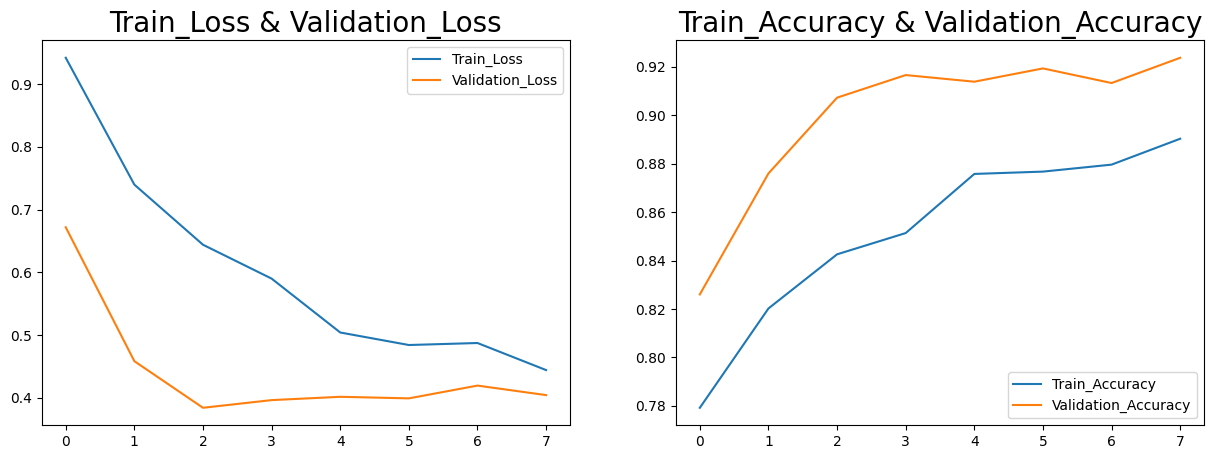

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

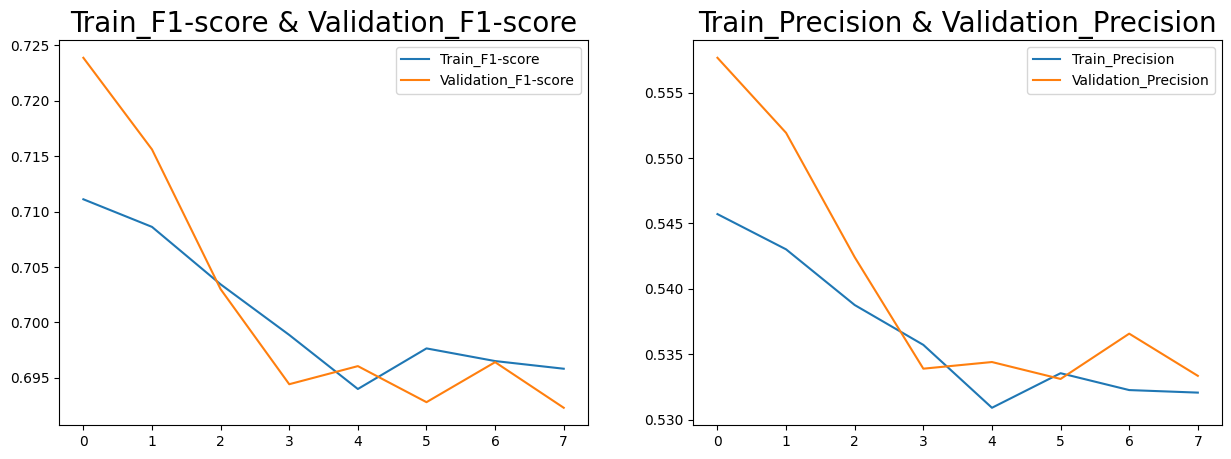

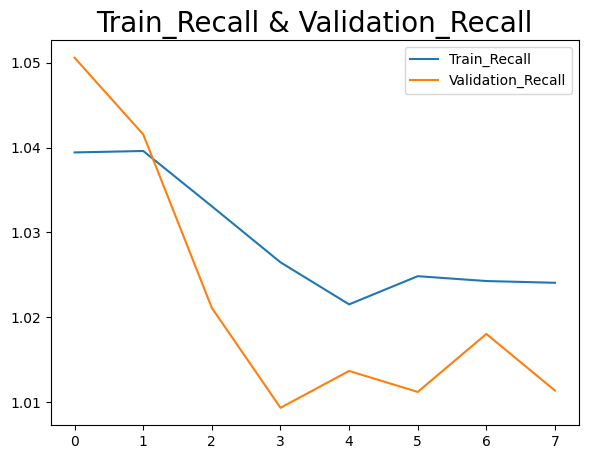

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['f1_m'],label='Train_F1-score')
plt.plot(hist_['val_f1_m'],label='Validation_F1-score')
plt.title('Train_F1-score & Validation_F1-score',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['precision_m'],label='Train_Precision')
plt.plot(hist_['val_precision_m'],label='Validation_Precision')
plt.title('Train_Precision & Validation_Precision',fontsize=20)
plt.legend()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['recall_m'],label='Train_Recall')
plt.plot(hist_['val_recall_m'],label='Validation_Recall')
plt.title('Train_Recall & Validation_Recall',fontsize=20)
plt.legend()


validation

In [ ]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=keras_model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

57/57 [==============================] - 2s 23ms/step


,Actual,Prediction
0,0,1
1,1,1
2,3,3
3,4,4
4,0,0
...,...,...
1817,1,0
1818,2,2
1819,0,0
1820,1,1


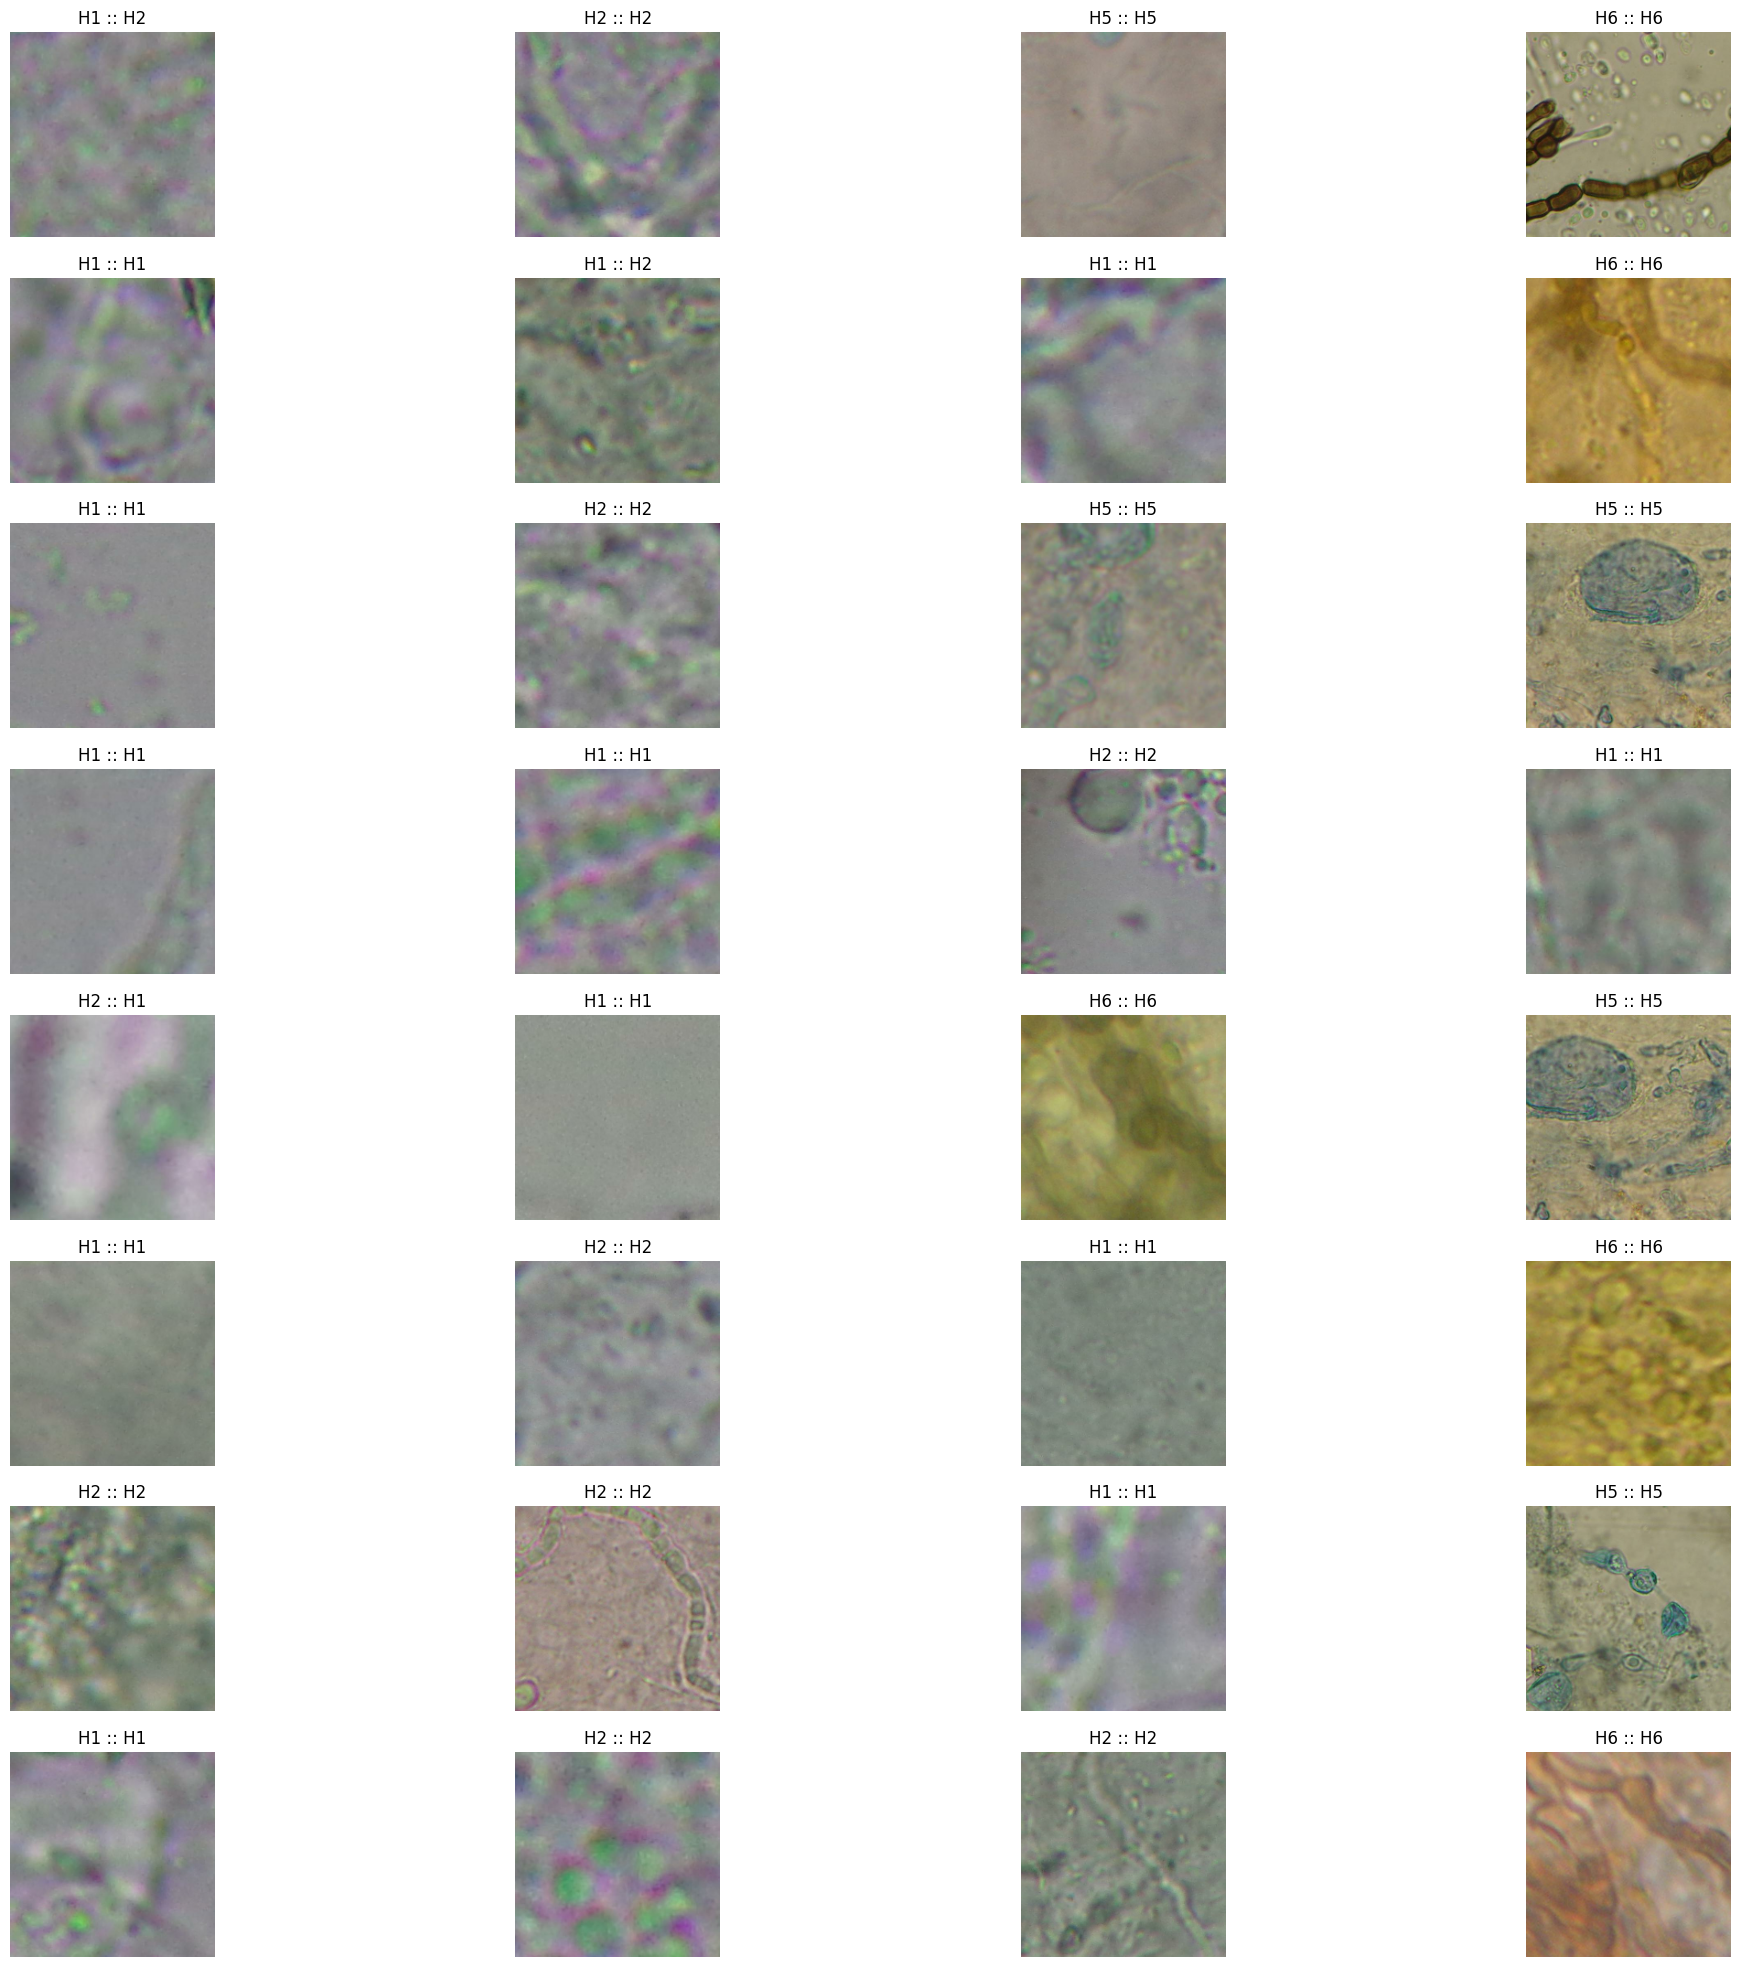

In [ ]:
class_names = train.class_names
class_names
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

Confusion_matrix

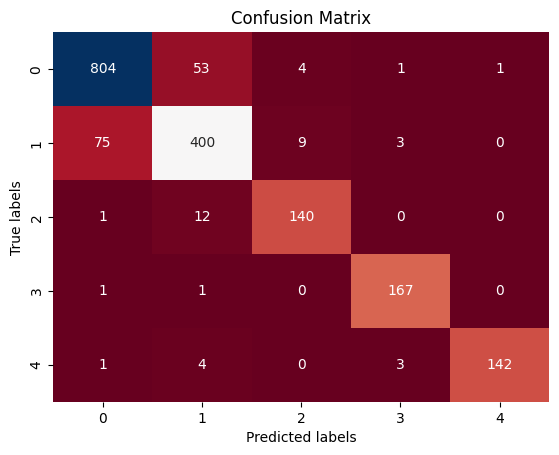

array([[804,  53,   4,   1,   1],
       [ 75, 400,   9,   3,   0],
       [  1,  12, 140,   0,   0],
       [  1,   1,   0, 167,   0],
       [  1,   4,   0,   3, 142]])

In [ ]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()
CM